https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

In [1]:
import pandas as pd
import numpy as np
from skimage.color import rgb2hed, hed2rgb, separate_stains, combine_stains
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'..')
from numpy.random import default_rng
import histomicstk as htk
from utils.data_utils import PNGTileGenerator, PandasDataLoader
import tensorflow as tf

In [2]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/masks'  # Path to the masks
NFOLDS = 4
SEED=1
TRAIN_FOLD=0
NUM_TILES=16
BATCH_SIZE=16

In [3]:
# an example: loading the skip dataframe and listing the possible reasons
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=[])

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_dp_sample(NFOLDS, SEED)

# we can create training/validation splits from the fold column
train_df = fold_df[fold_df['split'] != TRAIN_FOLD]
valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]

display(train_df)
display(valid_df)


possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
number of duplicates in the skip df: (13, 2)
Training dataframe after filtering: (9954, 4)
Number of rows removed by filter: 662
********************


../utils/data_utils.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = folds_splits
../utils/data_utils.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = folds_splits


,image_id,data_provider,isup_grade,gleason_score,split
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,3
18,007433133235efc27a39f11df6940829,radboud,0,negative,1
19,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,1
20,008069b542b0439ed69b194674051964,radboud,4,4+4,2
...,...,...,...,...,...
10617,ffbe854e810d4e4db8fc4acb3ac15333,karolinska,2,3+4,2
10618,ffc005d56a21efbd034425623f596984,karolinska,2,3+4,2
10619,ffc0cbbe28a6345a179d6210ef5c579f,karolinska,4,4+4,3
10622,ffcd99c47e57ad2934dc6bbf5edf6675,karolinska,0,0+0,2


,image_id,data_provider,isup_grade,gleason_score,split
22,00928370e2dfeb8a507667ef1d4efcbb,radboud,5,4+5,0
38,00f6ea010b008e7b3635910a13b165a5,radboud,1,3+3,0
41,010670e9572e67e5a7e00fb791a343ef,radboud,5,4+5,0
58,01a5e35b1ae21f3cfbe100b4b6aef451,radboud,4,4+4,0
61,01afe81220f729cf1c5b4d99f3abe559,radboud,4,4+4,0
...,...,...,...,...,...
10586,ff15dfc487071517ef450a09264af206,karolinska,0,0+0,0
10595,ff328f9aacb5c8844fb3907c5da69c77,karolinska,0,0+0,0
10596,ff339e5fa7be6af83c1b43796092398f,karolinska,4,4+4,0
10598,ff41de2d80bba4b7caf3e0694922601d,karolinska,1,3+3,0


In [4]:
data = PNGTileGenerator(train_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)
val_data = PNGTileGenerator(valid_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)

shape of batch (16, 16, 128, 128, 3)
(16, 512, 512, 3)


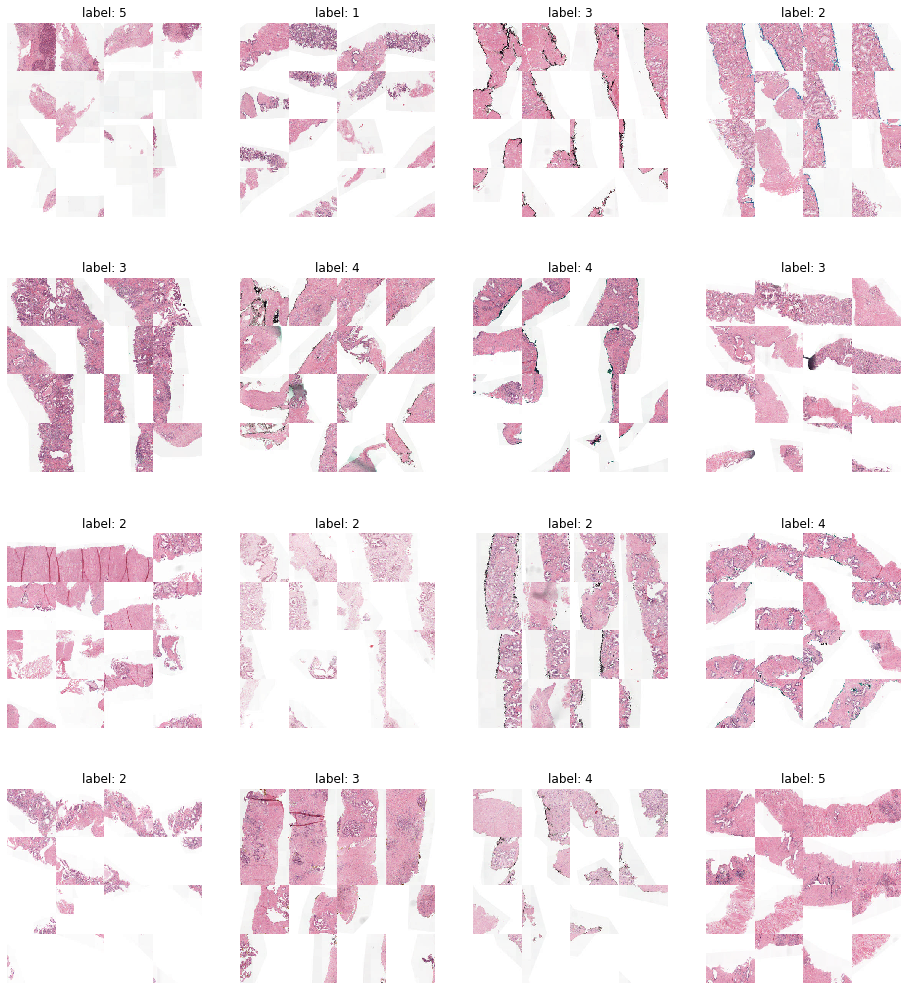

In [5]:
data.display_batch()

In [6]:
batch = data.get_batch()

(16, 16, 128, 128, 3)
(16, 512, 512, 3)
before stack (16, 512, 512, 3)
before figure (16, 16, 128, 128, 3)
(16, 16, 128, 128, 3)


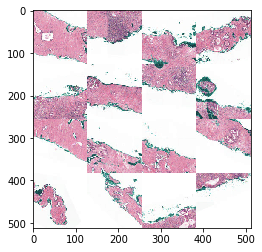

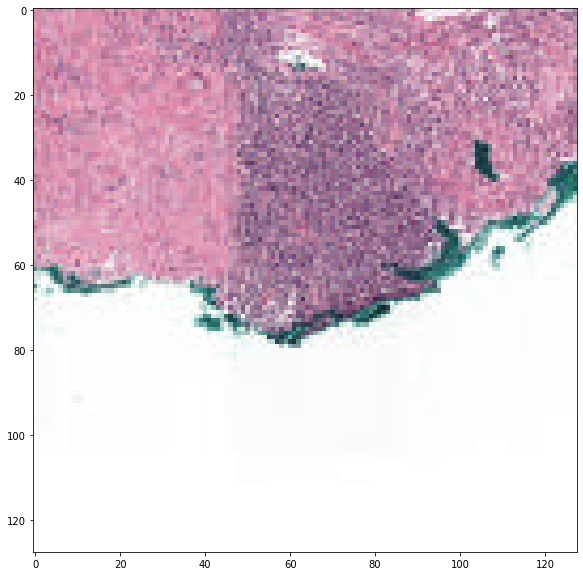

In [7]:
images = batch[0].numpy()
print(images.shape)
# we only need a single image, so grab one
img = np.reshape(images, (16, 4, 4, 128, 128, 3))
img = np.transpose(img, (0, 1, 3, 2, 4, 5))
img = np.reshape(img, (16, 128*4, 128*4, 3))
img = np.uint8(img*255)
plt.imshow(img[0,...])

new_img = img
print(img.shape)
print("before stack", new_img.shape)
new_img = new_img[:, np.newaxis, ...]
new_img = np.concatenate(np.split(new_img,4, axis=2), axis=1)
new_img = np.concatenate(np.split(new_img,4, axis=3), axis=1)

#new_img = np.reshape(new_img, (16, 16, 128, 128, 3))
print("before figure", new_img.shape)
plt.figure(figsize = (10,10))
print(new_img.shape)
plt.imshow(new_img[0,4,...])

new_img2=img

In [21]:
import imgaug.augmenters as iaa
from histomicstk.saliency.tissue_detection import get_tissue_mask
from histomicstk.preprocessing.augmentation.\
    color_augmentation import rgb_perturb_stain_concentration, perturb_stain_concentration
from skimage.transform import resize


def custom_aug(img, **kwargs):
    mask_out, _ = get_tissue_mask(
    img, deconvolve_first=False,
    n_thresholding_steps=1, sigma=5, min_size=30)

    mask_out = resize(
    mask_out == 0, output_shape=img.shape[:2],
    order=0, preserve_range=True) == 1
    
    augmented_rgb = rgb_perturb_stain_concentration(img, mask_out=mask_out)
    
    return augmented_rgb


def img_func(images, random_state, parents, hooks):
    for i,img in enumerate(images):
        images[i, ...] = custom_aug(img)
    return images

def keypoint_func(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images


def aug_pipeline(images):
    aug = iaa.Lambda(img_func, keypoint_func)
    new_aug = iaa.Sequential([aug])
    images_aug = aug(images=images)
    return images_aug



In [22]:
class PNGTileGenerator(object):
    """ Class that handles the loading and processing of concat tile pooling.

    The input is assumed to be a pandas dataframe function, and a path to
    the image folder.
    The images in the data folder are expected to contain PNG images,
    and represent shards of a larger image according to concat tile pooling
    i.e. a single image is represented by a batch of multiple images
    which is expressed in the filename according to the pattern
    <fname>_<X>.png where X represents the index of tiles per image, starting
    from 0.
    
    The dataframe must have the following columns: image_id, isup_grade
    """

    def __init__(self, df, img_dir, num_tiles=16, batch_size=8, aug=None):
        """ Initializer to the DataLoaderPNG class.

        Parameters
        ----------
        df : pandas dataframe
            The pandas dataframe with the image ids <image_id> and ISUP
            grades <isup_grade>
        img_dir : Pathlib Path
            Path to the image folder, must be a Pathlib Path object
        num_tiles : int, optional
            the number of tiles per image. The default is 16.
        batch_size : int, optional
            The batch size to be used during network training.
            The default is 8.
        aug: imgaug 
            an imgaug pipeline function
        Returns
        -------
        None.

        """
        self.df = df
        self.img_dir = tf.convert_to_tensor(str(img_dir))
        self.num_tiles = num_tiles
        self.num_classes = df['isup_grade'].nunique()
        self.batch_size = batch_size
        self.aug_func = aug
        # Tensorflow Dataset from the pandas df
        # Generate a dataset that yields (image_id, isup_grade) tuples
        self.isup_str = [str(x) for x in df['isup_grade'].tolist()]
        
        # Zip the image_id and isup dataset to yield tuple pairs (img_id, isup)
        new_ds = [*zip(self.df['image_id'].tolist(), self.isup_str)]
        
        # Create the dataset from the slices
        self.image_ids = tf.data.Dataset.from_tensor_slices(new_ds)
        
        # create a iter dataset for get_batch and display_batch methods
        self._ds_iter = iter(self.load_process())       
        
        
    
    def _load_images(self, img_ids):
        """ Vectorized function for loading images.

        Parameters
        ----------
        path : Tensorflow tensor containing byte strings
            A [batch_size,1] Tensor byte string containing image_id's'

        Returns
        -------
        A [batch_size, num_tiles, W, H, C] tensor
            The images in a [batch_size, num_tiles, W, H, C] tensor

        """
        def get_image_ids(path):
            """ Get all the image paths from the id.
                    
            Parameters
            ----------
            path : Tensor of byte strings
                A [batch_size,1] tensor of byte strings

            Returns
            -------
            image_ids : Tensor of byte strings
                A [batch_size * num_tiles] tensor of byte strings, containing
                the full paths to the corresponding image files
            """
            # Infer the shape from the batch itself
            batch_shape = tf.shape(path)
            
            # Append the image path to the id's: <img_dir>/<img_id>
            # size: [batch_size]
            image_ids = tf.strings.join([self.img_dir, path], separator='/')
            
            # There are num_tiles tile images sharing the same id
            # [batch_size * num_tiles] e.g.: [0, 1, 2] -> [0, 0, 1, 1, 2, 2]
            image_ids = tf.repeat(image_ids, self.num_tiles)
            
            # Create a list of indices [0:num_tiles]
            indices = tf.constant(list(range(0, self.num_tiles)))
            
            # [num_tiles * batch_size] -> [0:num_tiles 0:num_tiles]
            indices = tf.tile(indices, [batch_shape[0]])
            
            # Convert the numbers to strings for joining
            indices = tf.strings.as_string(indices)
            
            # Add indices to the filenames with tile indices
            image_ids = tf.strings.join([image_ids, indices], separator='_')
            
            # Add png extension
            image_ids = tf.strings.join([image_ids, 'png'], separator='.')
            return image_ids
        
        def read_img(path):
            """ Reads the image from a path.

            Parameters
            ----------
            image_id : Tensor
                A tensor with the paths

            Returns
            -------
            image : Tensor
                A [W,H,C] Tensor containing the image
            """
            image = tf.io.read_file(path)
            image = tf.io.decode_png(tf.squeeze(image), channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.strings.as_string(image)
            return image
        
        batch_shape = tf.shape(img_ids)
        # Get all the images in the dir, and their full path from the id
        image_paths = get_image_ids(img_ids)
        
        # [batch_size * num_tiles, W, H, C]
        # Vectorized map, since read_file and decode are not vectorizes funs
        images = tf.map_fn(read_img, image_paths)
        images = tf.strings.to_number(images, out_type=tf.dtypes.float32)
        
        dims = tf.shape(images)
        
        # Reshape to [batch_size, num_tiles, W, H, C]
        return tf.reshape(images, (batch_shape[0], self.num_tiles,
                                   dims[1], dims[2], dims[3]))
    
    def _load_label(self, label):
        """ Get the label from the string.

        Parameters
        ----------
        label : Tensor
            Contains label as byte string, can be an array of strings
            [batch_size,1] array of byte strings

        Returns
        -------
        label
            A [batch_size, num_classes] int32 tensor, containing a
            one hot representation of the labels
        """
        label = tf.strings.to_number(label, out_type=tf.int64)
        return tf.one_hot(tf.cast(label, dtype=tf.int32),
                          self.num_classes, dtype=tf.int32)
    
    def parse_img_label(self, img_label):
        """ Parse images and label from (image_id, label) pairs.

        Parameters
        ----------
        img_label : tuple
            A tuple of image_id and label

        Returns
        -------
        images : Tensor
            A [batch_size, num_tiles, W, H, C] Tensor in float32, containing
            the image
        label : Tensor
            A [batch_size, num_classes] Tensor containing a one hot
            representation of the labels
        """
        path, label = img_label[:, 0], img_label[:, 1]
        
        label = self._load_label(label)
        images = self._load_images(path)
        
        return images, label
    
    def aug(self, images, label):
        
        dims = tf.shape(images)
        bs, nt, w ,h ,c = dims[0], dims[1], dims[2], dims[3], dims[4]
        
        # square root of num tiles
        sqnt = tf.cast(tf.math.sqrt(tf.cast(nt, tf.float32)), tf.int32)
        
        # reshape to [bs, sqrt(nt), sqrt(nt), w, h, c]
        images = tf.reshape(images, (bs, sqnt, sqnt, w, h, c))
        # transpose to [bs, w, sqrt(nt), h, sqrt(nt), c]
        images = tf.transpose(images, (0, 1, 3, 2, 4, 5))
        # reshape to [bs, w * sqrt(nt), h * sqrt(nt), c]
        # The image is now all tiles stacked together into a sqnt*sqnt grid
        images = tf.reshape(images, (bs, w*sqnt, h*sqnt, c))
        # augmentations work on uint8 images
        images = tf.image.convert_image_dtype(images, 
                                              tf.uint8, 
                                              saturate=False, 
                                              name='pre_aug_cast')
        shapes = images.get_shape()
        
        images = tf.numpy_function(self.aug_func, [images], tf.uint8, 
                                   name='augmentation')  
        images = tf.image.convert_image_dtype(images, tf.float32, 
                                              saturate=False, 
                                              name='post_aug_cast')

        
        # for some reason, I can't fill in bs,nt,w,h,c into set_shape...
        images.set_shape(shapes)
        
        images = tf.expand_dims(images, 1)
        images = tf.concat(tf.split(images,4, axis=2), axis=1)
        images = tf.concat(tf.split(images,4, axis=3), axis=1)
        
        return images, label
        
    def load_process(self,
                     mode='training',
                     cache=False,
                     shuffle_buffer_size=1000):
        """ Create a Tensorflow dataset that returns (image, label) pairs.
        
        Configuring the best pipeline is hard to do. We used the following
        guidelines to create a pipeline that is at least performing decently
        https://www.tensorflow.org/guide/data#randomly_shuffling_input_data
        https://www.tensorflow.org/guide/data_performance#vectorizing_mapping
        https://www.tensorflow.org/datasets/performances

        Parameters
        ----------
        mode : string, optional
            either 'validation' or 'training. The default is 'training'.
        cache : bool or string, optional
            A boolean to use cache, or a string to the tfcache location e.g.
            <path-to-cache.tfache> . The default is False.
        shuffle_buffer_size : TYPE, optional
            DESCRIPTION. The default is 10000.

        Returns
        -------
        ds : Tensorfloat Dataset
            can be directly fed into Keras pipeline, or eagerly executed
            in for loops. Will yield batches of batch_size containing
            image/label pairs of size ([num_tiles, W, H, C], num_classes)
        """
        
        assert mode in ('training', 'validation')
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        # shuffle before map (list of filenames is more efficient)
        if mode == 'training':
            ds = self.image_ids.shuffle(shuffle_buffer_size, seed=1)
        else:
            ds = self.image_ids
        
        # batch before map: vectorize operations
        ds = ds.batch(self.batch_size, drop_remainder=False)
        
        # use cache(filename) to cache preprocessing work for datasets
        # that do not fit in memory
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()
        
        # map 1: transform to images
        ds = ds.map(self.parse_img_label, num_parallel_calls=AUTOTUNE)
        
        # TODO: map2: augmentations and other operations (random)
        if self.aug_func is not None:
            ds = ds.map(self.aug, num_parallel_calls=AUTOTUNE)
        
        # `prefetch` lets the dataset fetch batches in the background
        # while the model is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    def get_batch(self):
        """ Retrieve a batch from the dataset.
        
        Returns
        -------
        TF Tensor
            A [batch_size, num_tiles, W, H, C] array
            of images in Tensor format
        """
        return next(self._ds_iter)
   
    def display_batch(self, batch=None, plot_grid = (4,4)):
        """ Plot a batch of images.
        
        Parameters
        ----------
        batch : TF Tensor or numpy array, optional
            A [batch_size, num_tiles, M, N, C] array of images.
            The default is None.
        plot_grid: tuple of ints
            A tuple of ints displaying the grid for the plot
            
        Returns
        -------
        None.
        """
        if batch is None:
            batch = self.get_batch()
         
        # The batch is [BS, NT, W, H, C], this is not a supported format
        # Loop over the batch (rows) and num_tiles (columns) and display
        img_batch, label_batch = batch
        img_batch = img_batch.numpy()
        label_batch = label_batch.numpy()
        label_batch = np.argmax(label_batch, axis=1)
        
        bs, nt, w, h, c = img_batch.shape
        sqnt = int(np.sqrt(nt))
        print("shape of batch", img_batch.shape)
        img_batch = np.reshape(img_batch, (bs,
                                           sqnt,
                                           sqnt,
                                           w, h, c))
        
        img_batch = np.transpose(img_batch, (0, 1, 3, 2, 4, 5))
        img_batch = np.reshape(img_batch, (bs, w * sqnt, h * sqnt, c))
        img_batch = np.uint8(img_batch * 255)
        fig, ax = plt.subplots(plot_grid[0], plot_grid[1], figsize=(16, 18))
        print(img_batch.shape)
        # Plot each image in the dataframe
        tot = 0
        for row in range(plot_grid[0]):
            for col in range(plot_grid[1]):
                ax[row, col].imshow(img_batch[tot, ...])
                ax[row, col].axis('off')
                ax[row, col].set_title(f'label: {label_batch[tot]}')
                tot +=1
                
    def display_augmentation(self):
        '''Display augmentations of a single image of tiles

        Returns
        -------
        None.

        '''
        # Temporarily change the batch size
        temp = self.batch_size
        self.batch_size = 1
        
        # Shuffle buffer to 1 eliminates shuffling
        ds = self.load_process(shuffle_buffer_size=1)
        
        # Create a batch to parse to display_batch
        ds = next(iter(ds.unbatch().take(1).repeat(16).batch(16)))
        
        # display
        self.display_batch(ds, plot_grid=(4,4))
        
        # reset the batch size to the original value
        self.batch_size = temp
                
    def __call__(self, mode='training'):
        """Call method, that returns the dataset defined in self.load_process.

        Parameters
        ----------
        mode : string, optional
            either 'training' or 'validation'. The default is 'training'.
            validation will not repeat or shuffle

        Returns
        -------
        Tensorflow Dataset
            can be directly fed into Keras pipeline, or eagerly executed
            in for loops. Will yield batches of batch_size containing
            image/label pairs of size ([num_tiles, W, H, C], num_classes)
        """
        assert mode in ('training', 'validation')
        
        # return a dataset
        return self.load_process(mode)

In [23]:
data = PNGTileGenerator(train_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE, aug=aug_pipeline)

shape of batch (16, 16, 128, 128, 3)
(16, 512, 512, 3)


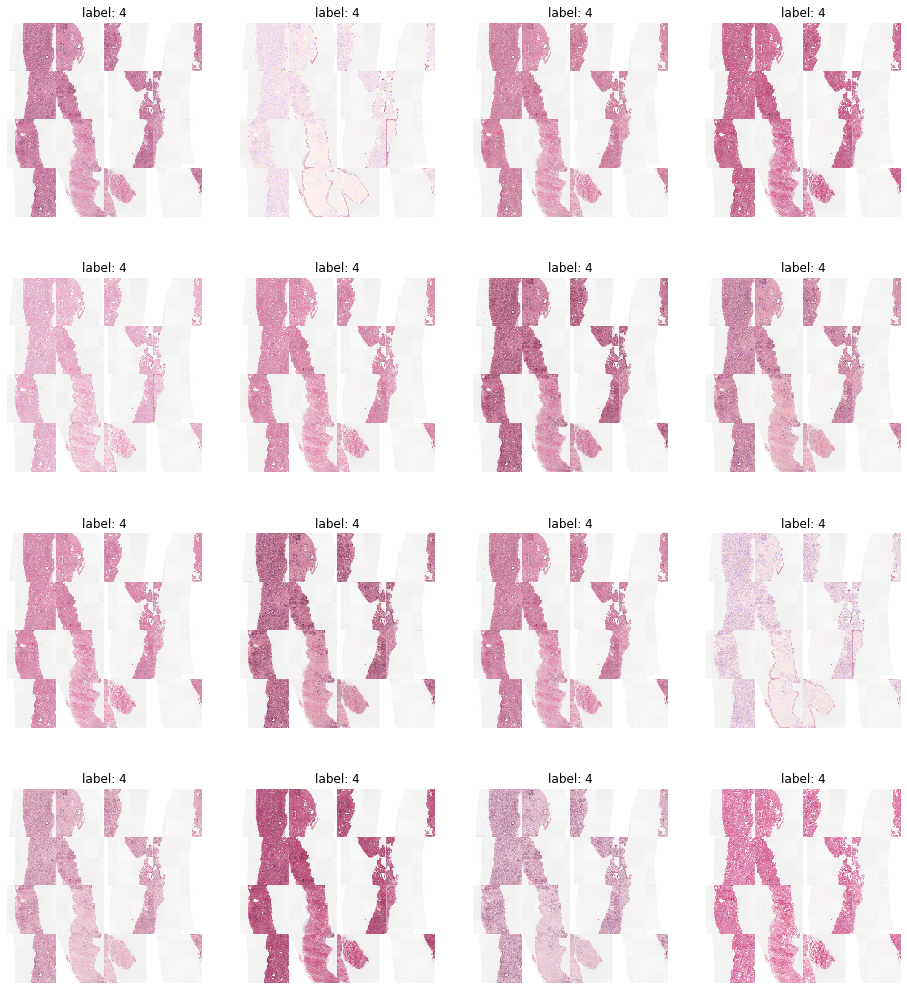

In [24]:
data.display_augmentation()